In [13]:
import Bio
import tqdm
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
import json

# Change this email to your email address
Entrez.email = "example.d@gmail.com"

keyword = "GPS water storage"

result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
print(
    "Total number of publications that contain the term {}: {}".format(
        keyword, result["Count"]
    )
)

# Fetch all ids
MAX_COUNT = result["Count"]
result = Entrez.read(
    Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
)

ids = result["IdList"]

batch_size = 50
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

Total number of publications that contain the term GPS water storage: 28


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]

Complete.


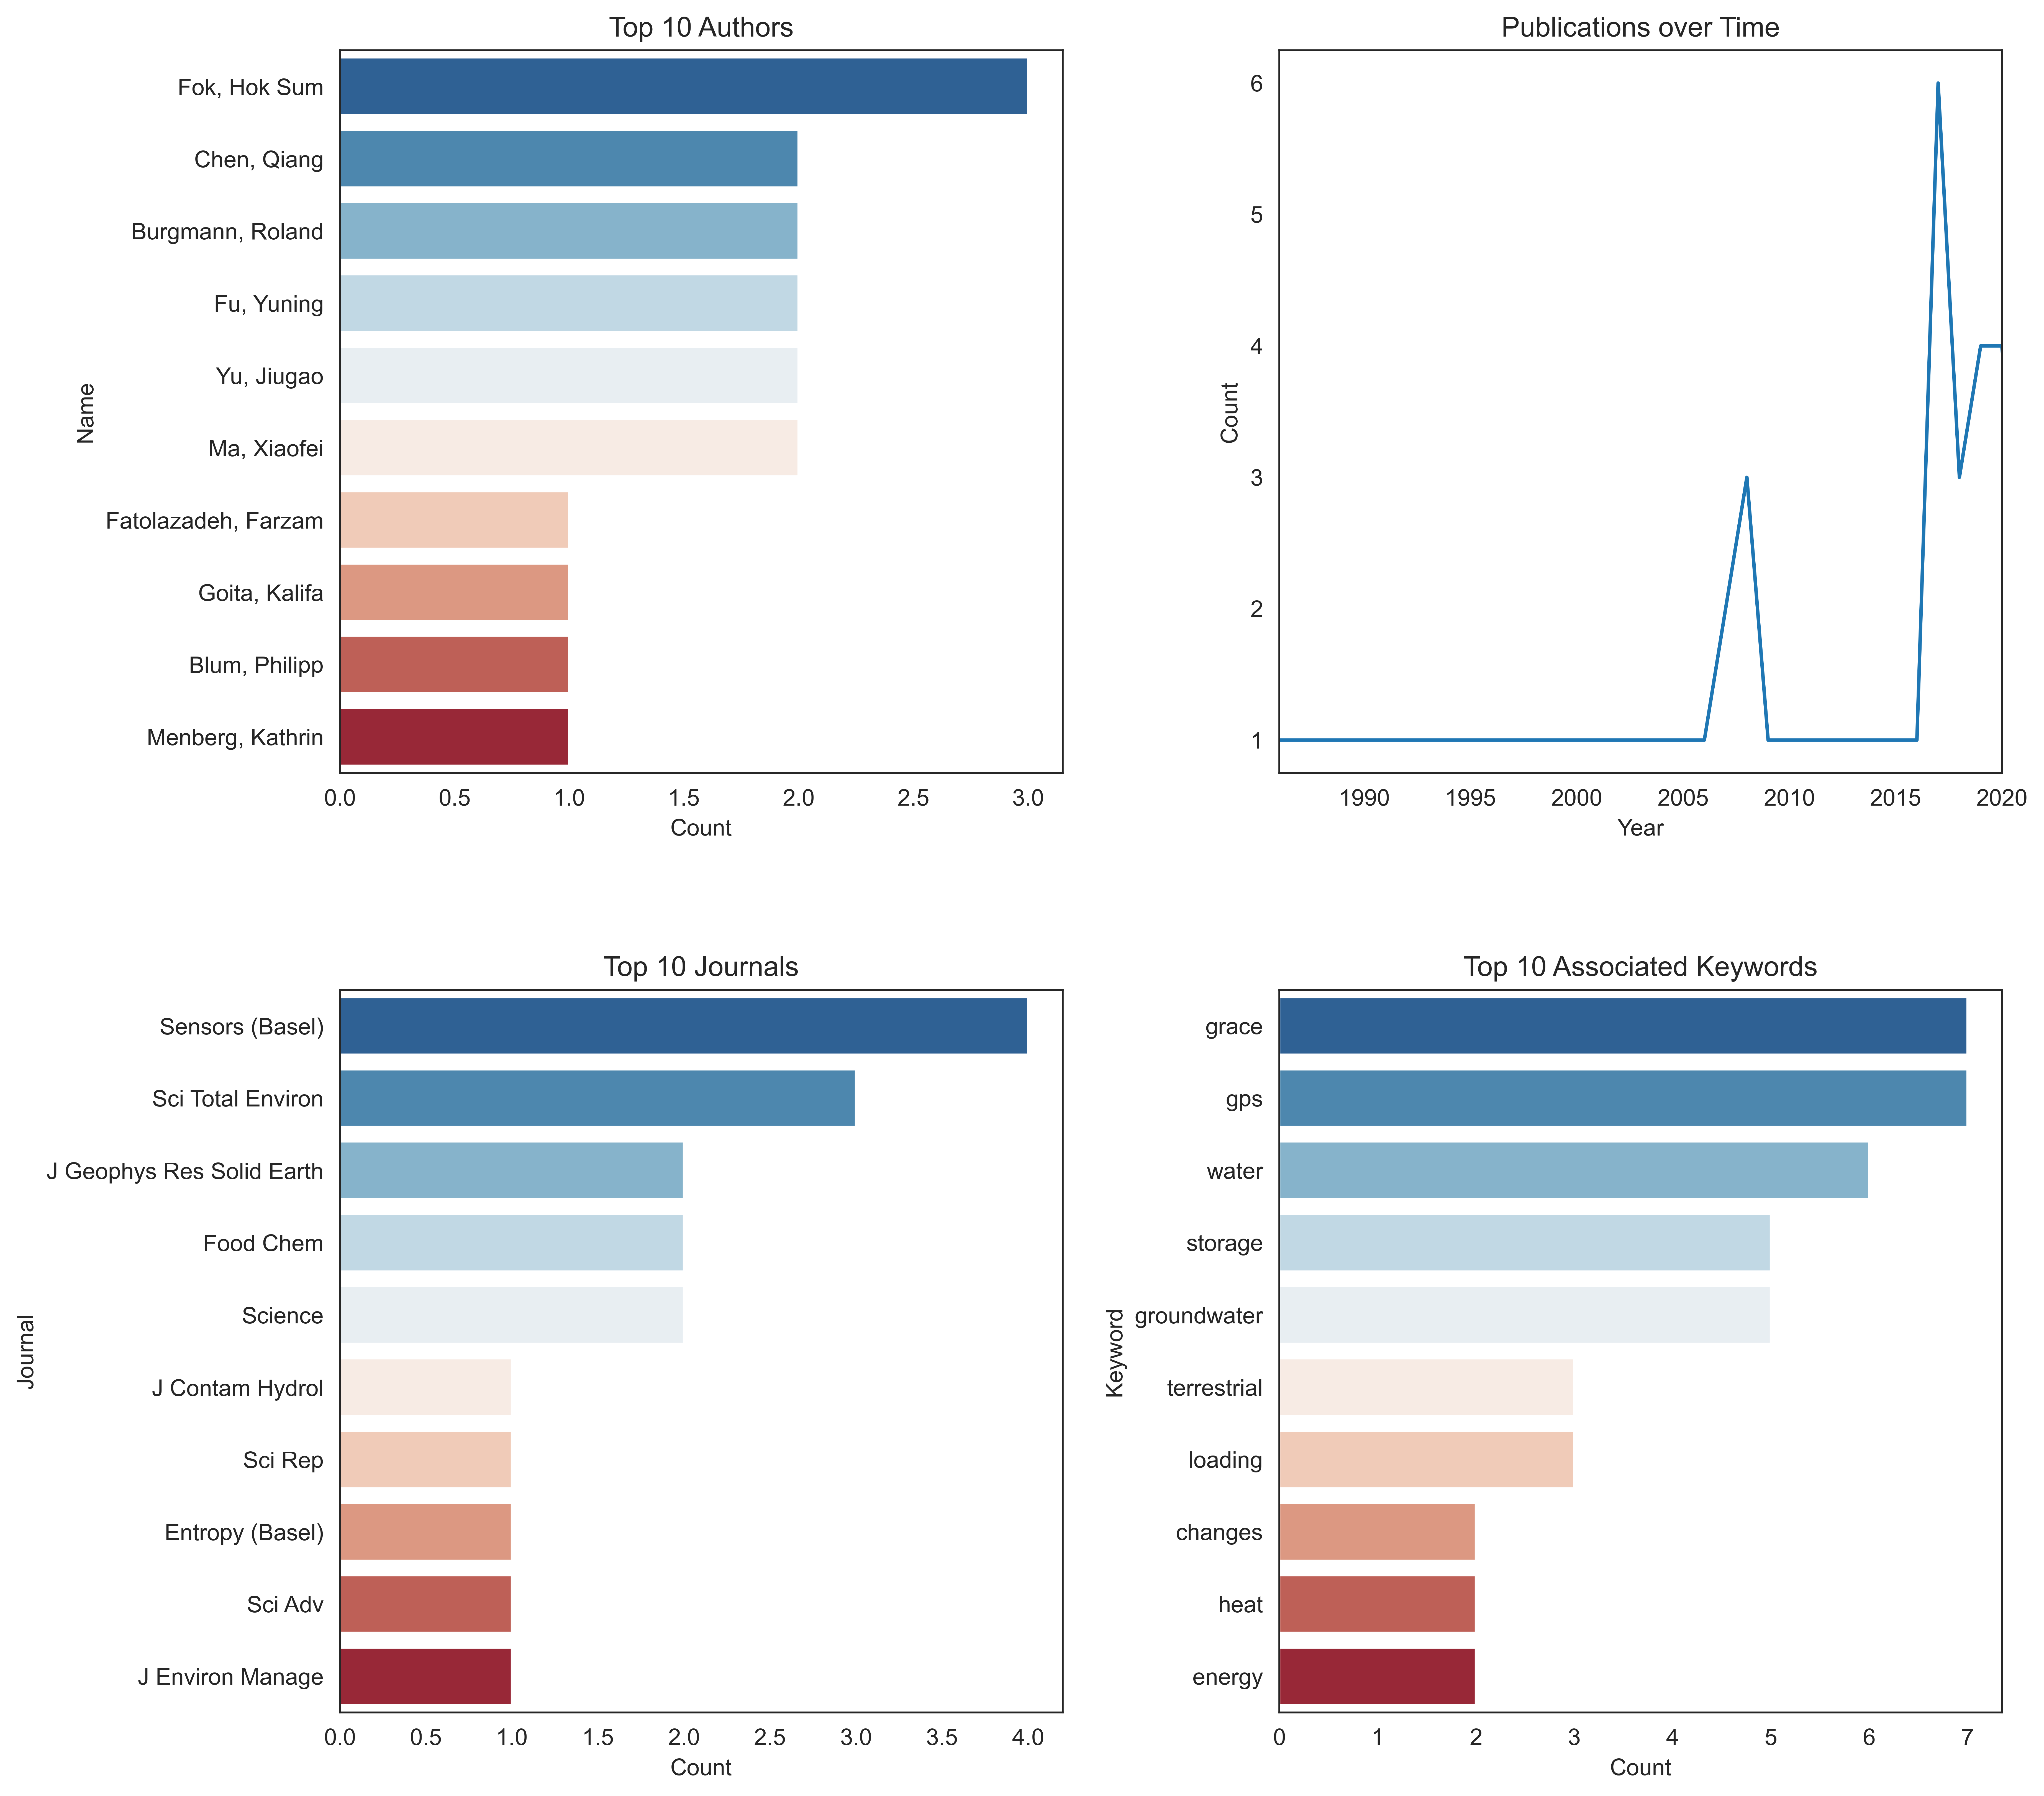

In [17]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(10, 10), dpi=600)

# Top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")
plt.xlim([1986, 2020])


plt.subplot(2, 2, 3)

# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["TA"]).most_common(10),
    columns=["Journal", "Count"],
)

sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [
    _.lower()
    for kws in list(publication_data["OT"].dropna())
    for kw in kws
    for _ in kw.split(" ")
]

top10kw = pd.DataFrame.from_records(
    Counter(flat_kw).most_common(10), columns=["Keyword", "Count"]
)

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

In [15]:
from itertools import combinations
import networkx as nx
from nxviz import plots

# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

df_graph_50 = G.subgraph(top50_nodes)
G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )

print(df_graph_50)

df.to_csv('h_geodessy_connections.csv')


Graph with 50 nodes and 111 edges


In [4]:
#list(df_graph_50)
#list(G)
#list(flat_connections)
#list(df)

c = flat_connections
print(c)


[('Goita, Kalifa', 'Fatolazadeh, Farzam'), ('Bayer, Peter', 'Hemmerle, Hannes'), ('Bayer, Peter', 'Tissen, Carolin'), ('Bayer, Peter', 'Benz, Susanne A'), ('Bayer, Peter', 'Koch, Fabien'), ('Bayer, Peter', 'Menberg, Kathrin'), ('Bayer, Peter', 'Blum, Philipp'), ('Hemmerle, Hannes', 'Tissen, Carolin'), ('Hemmerle, Hannes', 'Benz, Susanne A'), ('Hemmerle, Hannes', 'Koch, Fabien'), ('Hemmerle, Hannes', 'Menberg, Kathrin'), ('Hemmerle, Hannes', 'Blum, Philipp'), ('Tissen, Carolin', 'Benz, Susanne A'), ('Tissen, Carolin', 'Koch, Fabien'), ('Tissen, Carolin', 'Menberg, Kathrin'), ('Tissen, Carolin', 'Blum, Philipp'), ('Benz, Susanne A', 'Koch, Fabien'), ('Benz, Susanne A', 'Menberg, Kathrin'), ('Benz, Susanne A', 'Blum, Philipp'), ('Koch, Fabien', 'Menberg, Kathrin'), ('Koch, Fabien', 'Blum, Philipp'), ('Menberg, Kathrin', 'Blum, Philipp'), ('Ojha, C', 'Zhai, G'), ('Ojha, C', 'Werth, S'), ('Ojha, C', 'Shirzaei, M'), ('Ojha, C', 'Carlson, G'), ('Zhai, G', 'Werth, S'), ('Zhai, G', 'Shirzaei, M

In [8]:
#create a dictionary, d, with all names from c (with no repeats), and an index
d = {}
Id = 0
for t in c:
    if t[0] not in d.keys():
        d[t[0]] = Id
        Id = Id+1
    if t[1] not in d.keys():
        d[t[1]] = Id
        Id = Id+1

#create a dictionary, dd, of each name and index from d. These are nodes.
dd = {}
dd["nodes"] = []
for k in d.keys():
    dd["nodes"].append({"name":k,"index": d[k]})

#Create a dictionary of author/coauthor pairs from original list (c), but have the index number in place of name
dd["links"] = []
for t in c:
    dd["links"].append({"target":d[t[0]],"source": d[t[1]]})

#print(dd)

print(json.dumps(dd, sort_keys=True, indent=2))

{
  "links": [
    {
      "source": 1,
      "target": 0
    },
    {
      "source": 3,
      "target": 2
    },
    {
      "source": 4,
      "target": 2
    },
    {
      "source": 5,
      "target": 2
    },
    {
      "source": 6,
      "target": 2
    },
    {
      "source": 7,
      "target": 2
    },
    {
      "source": 8,
      "target": 2
    },
    {
      "source": 4,
      "target": 3
    },
    {
      "source": 5,
      "target": 3
    },
    {
      "source": 6,
      "target": 3
    },
    {
      "source": 7,
      "target": 3
    },
    {
      "source": 8,
      "target": 3
    },
    {
      "source": 5,
      "target": 4
    },
    {
      "source": 6,
      "target": 4
    },
    {
      "source": 7,
      "target": 4
    },
    {
      "source": 8,
      "target": 4
    },
    {
      "source": 6,
      "target": 5
    },
    {
      "source": 7,
      "target": 5
    },
    {
      "source": 8,
      "target": 5
    },
    {
      "source": 7,
      "tar

In [6]:
dd = {}
dd['nodes'] = []

for k in d.keys():
    dd["nodes"].append({"name":k,"index": d[k]})

In [7]:
#Failed attempts
d2 = {}
for t in c:
    if t[0] == c[0]:
        d[t[1]] = c[1]
    if t[]
    
print(d2)

ddd = {}
ddd["links"] = []

for k in d.keys():
    ddd["links"].append({"source":k,"target": d[k]})


print(d['Materna, Kathryn'])
print(d)

SyntaxError: invalid syntax (2066385147.py, line 6)